# Spatial transcriptomics exercise

Please hand in the completed ipynb and a html or pdf version of the notebook by email to daria.romanovskaia@helmholtz-munich.de by **27.01.2026**.

The exercise was kindly provided by louis.kummerle@helmholtz-munich.de

For any qustions please contact the tutors of the seminar (Daria Romanovskaia, Benedikt Roth, Sarah Ouologuem, Xiatong Fu) on Slack.

You will get familiar to spatial transcriptomics analyses by looking at data from the human heart.

There is a total of 50 points that can be achieved.

## Installing and running
The exercise can be implemented in this google colab notebook. If you want to work on colab, please create a copy of the notebook. Alternatively you can download the ipynb notebook and work on your local jupyter server. For the local setup to work, please install python 3.10 and jupyter on your laptop.

In both cases you need to install the squidpy package.

In [ ]:
!pip install squidpy

## Import packages

In [ ]:
import anndata as ad
import scanpy as sc
import squidpy as sq
import pandas as pd
import zipfile

## for downloading
from pathlib import Path
from urllib.request import urlretrieve

## Exercise 1: deconvolution of spot based data from the human heart

The data for this exercise comes from the version 2 of the human heart cell atlas published in this paper:

*Spatially resolved multiomics of human cardiac niches*
* https://www.nature.com/articles/s41586-023-06311-1
* https://www.heartcellatlas.org/


In the paper, the authors characterized the cells of the cardiac conduction system. The data was obtained using the spot based Visium platform on the one hand and using single nucleus RNA-seq.

**Aim of this exercise: understand and reproduce figure 1 c-f of the paper**

![image on the nature website](https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41586-023-06311-1/MediaObjects/41586_2023_6311_Fig1_HTML.png?as=webp)

Download the exercise data

In [12]:
DATA_DIR = Path("./data")
DATA_DIR.mkdir(exist_ok=True, parents=True)

urls = [
    # Ex 1.2
    "https://cellgeni.cog.sanger.ac.uk/heartcellatlas/v2/SAN_aCMs_lognormalised.h5ad",
    "https://cellgeni.cog.sanger.ac.uk/heartcellatlas/v2/AVN_aCMs_lognormalised.h5ad",
    # Ex 1.5
    "https://cellgeni.cog.sanger.ac.uk/heartcellatlas/visium/OCT/HCAHeartST10659160.h5ad",
    "https://cellgeni.cog.sanger.ac.uk/heartcellatlas/visium/OCT/HCAHeartST13228103.h5ad",
]

for url in urls:
    print(f"Downloading {url}...")
    urlretrieve(url, DATA_DIR / Path(url).name)

### Exercise 1.1: Describe the UMAPs in the paper (5 points)

Please read the [paper](https://www.nature.com/articles/s41586-023-06311-1) and describe what is shown in Figure 1c) and 1d)?

a) what kind of data is the UMAP built from?

b) which cells were selected for visualization?

c) cells of which cell type are highlighted in panels c-d?



Figure 1c and 1d: these figures show UMAP embeddings from single-nucleus RNA-seq data of human cardiac cells. They highlight specific 'pacemaker' cell clusters within the cardiac conduction system.


a) UMAP data is built from single-cell/ single-nucleus RNA-seq data --> the data is integrated from several sources. The data was processed for batch correction and dimensionality reduction.

b) atrial cardiomyocytes from the sinoatrial node region (fig. 1c), and atrial and ventricular cardiomyocytes from the atrioventricular node region (fig. 1d)

c) pacemaker cells --> SAN P cells expressing markers HCN1, CACNA1D, TBX3 (fig. 1c), atrioventricular node pacemaker cells expressing markers such as HCN4, CACNA1D, TBX3, etc. (fig. 1d)

### Exercise 1.2: Reproduce the UMAPs from the paper (2 points)
Reproduce the plot in Figure 1c) and 1d) using data in `AVN_aCMs_lognormalised.h5ad` and `SAN_aCMs_lognormalised.h5ad`. The celltype annotation is contained in the `obs` data frame of these anndata objects.

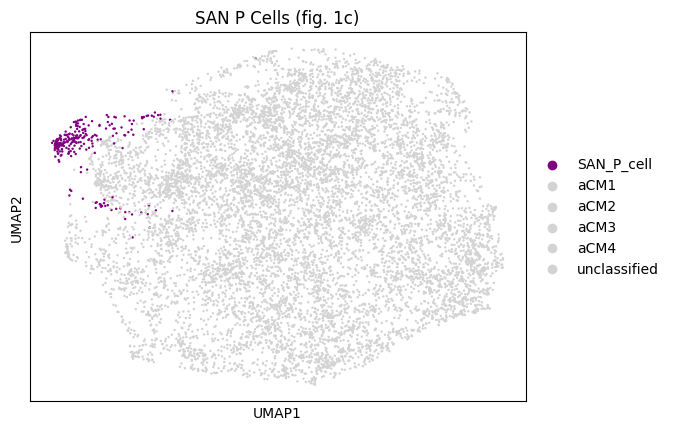

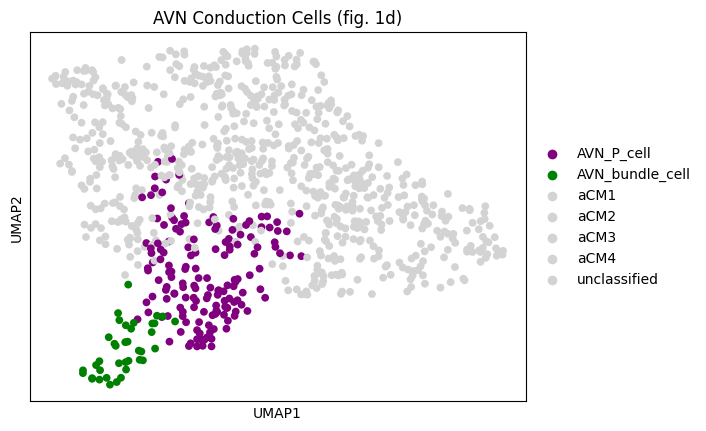

In [10]:
avn = sc.read_h5ad('/home/emma/PycharmProjects/gobi/Semester/Exercise6/data/AVN_aCMs_lognormalised.h5ad')
san = sc.read_h5ad('/home/emma/PycharmProjects/gobi/Semester/Exercise6/data/SAN_aCMs_lognormalised.h5ad')

san_colours = {
    'SAN_P_cell': '#800080',  # purple
    'aCM1': '#D3D3D3',       # liht grey
    'aCM2': '#D3D3D3',
    'aCM3': '#D3D3D3',
    'aCM4': '#D3D3D3',
    'unclassified': '#D3D3D3'
}

sc.pl.umap(san, color='cell_state', palette=san_colours, title='SAN P Cells (fig. 1c)')

avn_colours = {
    'AVN_P_cell': '#800080',      # purple
    'AVN_bundle_cell': '#008000', # green
    'aCM1': '#D3D3D3',           # light grey
    'aCM2': '#D3D3D3',
    'aCM3': '#D3D3D3',
    'aCM4': '#D3D3D3',
    'unclassified': '#D3D3D3'
}

sc.pl.umap(avn, color='cell_state', palette=avn_colours, title='AVN Conduction Cells (fig. 1d)')

### Exercise 1.3: cell type deconvolution using cell2location (10 points)
Please read the cell2location [paper](https://www.nature.com/articles/s41587-021-01139-4) and the cell2location [documentation](https://cell2location.readthedocs.io/en/latest/index.html).

a) what is the input to cell2location?

b) what are the key steps in cell2location and which functions in the code do they correspond to?

c) what is the output of cell2location?

a) there are two main inputs: untransformed spatial mRNA count matrices and reference cell type signatures, hyperparameters include expected number of nuclei per spatial location

b) cell2location.models.RegressionModel --> reference signature estimation (negative binomial regression)
cell2location.models.Cell2Location --> spatial mapping (check mRNA counts in each spatial spot)

c) the output is per-loction cell type abundances, posterior distributions for uncertainty, and decompositions such as NMF factors for tissue zones

### Exercise 1.4: cell type signature for spatial deconvolution (12 points)

Now we turn to the spot based spatial transcriptomics data that was generated using the Visum technology. This data was analysed using cell2location (see introductory talk).

We followed the code of the publication to learn the cell type signatures of the snRNA-seq data. The code is available here:
https://github.com/Teichlab/HCA_Heart_ver2/blob/main/Visium/1_cell2location/reference-signature_revision_SAN-AVN.ipynb

The following code chunk downloads and extracts the data.


In [13]:
url = "https://hmgubox2.helmholtz-muenchen.de/index.php/s/XPN7fy5GQY3aZ6z/download"
urlretrieve(url, DATA_DIR / 'cell2location.zip')
with zipfile.ZipFile(DATA_DIR / "cell2location.zip", 'r') as zip_ref:
    zip_ref.extractall(DATA_DIR)

The output files `sc.h5ad`, `model.pt`, `inf_aver.csv` are available here:
`DATA_DIR / "cell2location" / "reference-signatures" / <"AVN"/"SAN">`. When you work on google colab, you can see the files when you click on the files folder icon on the left.

**Our goal now is to verify the cell type signatures:**

a) Find the top 10 DE genes for the follwing 3 groups in AVN: P cells, bundle cells, and other cells.

b) Generate a dotplot of the marker genes over the 3 groups.

c) Based on the dotplot select 10 marker genes that are specific for 1 (or 2) of the 3 groups.

d) Create a heatmap or a table to visualize and check the `means_per_cluster_mu_fg` of the different states in AVN and discuss if the learned signatures fit to the marker expressions.

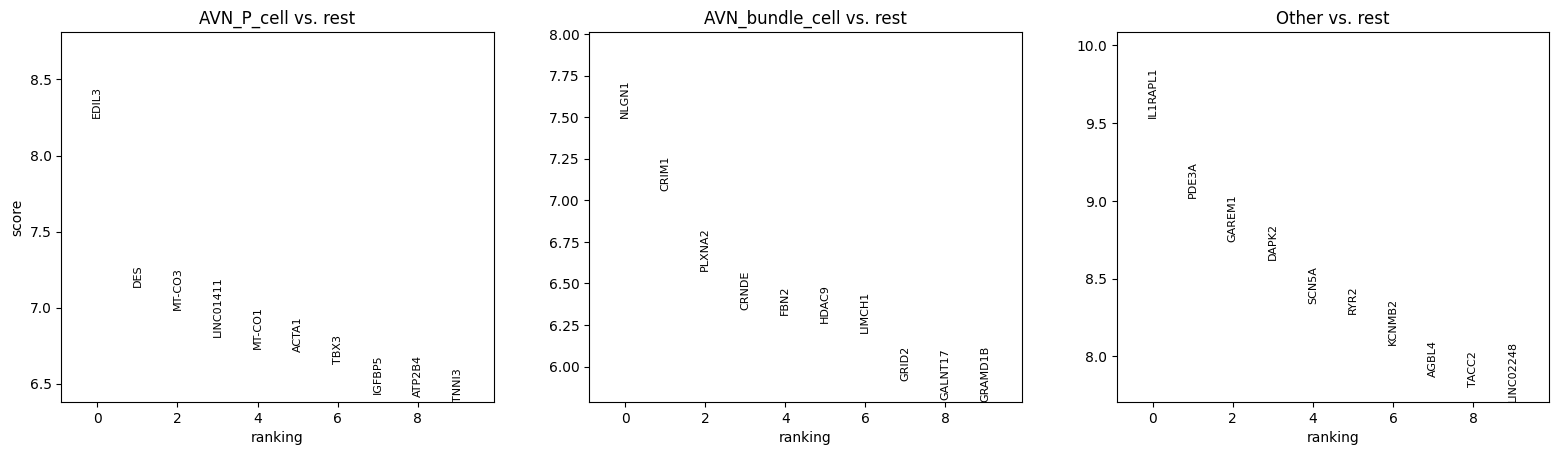

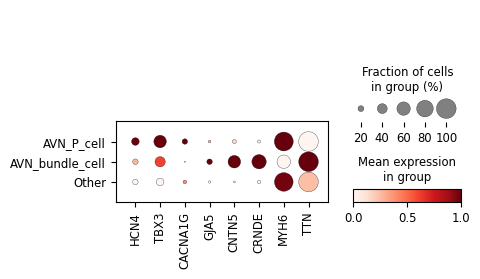

In [14]:
# solutions a, b

# clusters
avn.obs['grouped_states'] = avn.obs['cell_state'].astype(str)
avn.obs.loc[~avn.obs['grouped_states'].isin(['AVN_P_cell', 'AVN_bundle_cell']), 'grouped_states'] = 'Other'

# DE genes
sc.tl.rank_genes_groups(avn, 'grouped_states', method='wilcoxon')
sc.pl.rank_genes_groups(avn, n_genes=10, sharey=False)

# markers
markers = ['HCN4', 'TBX3', 'CACNA1G', 'GJA5', 'CNTN5', 'CRNDE', 'MYH6', 'TTN']

sc.pl.dotplot(avn, markers, groupby='grouped_states', standard_scale='var')


In [26]:
# solution c
selected_markers = ['HCN4', 'TBX3', 'TBX5', 'GJA5', 'SCN5A', 'CRNE', 'MYH6', 'TNN', 'CACNA1C', 'MYL2']

print('10 specific marker genes:', selected_markers)

10 specific marker genes: ['HCN4', 'TBX3', 'TBX5', 'GJA5', 'SCN5A', 'CRNE', 'MYH6', 'TNN', 'CACNA1C', 'MYL2']


In [27]:
# solution d
avn = sc.read_h5ad('/home/emma/PycharmProjects/gobi/Semester/Exercise6/data/cell2location/reference_signatures/AVN/sc.h5ad')

print("Check keys:", list(avn.uns.keys()) + list(avn.var.columns))

#TODO: wtf??

Check keys: ['_scvi_manager_uuid', '_scvi_uuid', 'mod', 'gene_name-new', 'gene_name_scRNA-0-original', 'gene_name_snRNA-1-original', 'gene_name_multiome-2-original', 'n_cells', 'nonz_mean']



### Exercise 1.5: Reproduce figure 1f) (6 points)
Using these celltype signatures, cell2location has been applied to the Visium data sets in `HCAHeartST10659160.h5ad` for the first (left) panel of figure 1f) and `HCAHeartST13228103.h5ad` for the second and third panel of figure 1f). In each file, the `obsm` data frame contains the results of the cell2location deconvolution. Please refer to the [documentation](https://cell2location.readthedocs.io/en/latest/cell2location.html) of the `export_posterior` function to identify the relevant column that carries the information on the mean abundance per cell type.

Copy the abundance estimates of the cell types shown in the panels of Figure 1f) as new columns of the anndata `obs` data frame.

Identify the scanpy plotting function that is best suited for visualization of spatial data from the [documentation](https://scanpy.readthedocs.io/en/latest/api/plotting.html).

a) Use this function to plot the spatial distribution of the cell type abundance estimates created by cell2location in the three leftmost panels of figure 1f).

b) Based on your three plots and the [paper](https://www.nature.com/articles/s41586-023-06311-1): explain which of the cell types of the cardiac conduction system are localized in which physiological regions?

/tmp/ipykernel_179604/3293151704.py:15: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


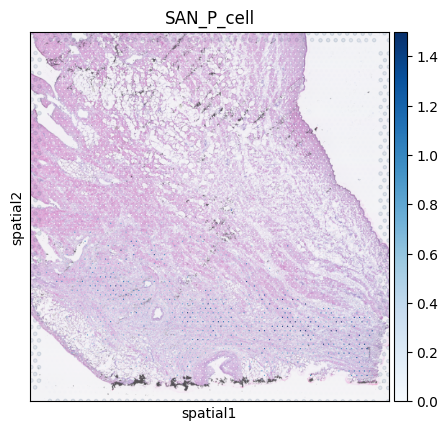

/tmp/ipykernel_179604/3293151704.py:26: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


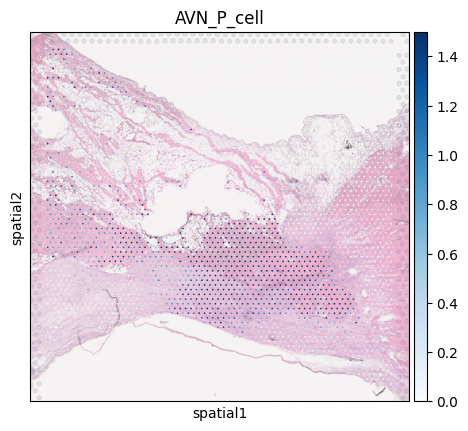

/tmp/ipykernel_179604/3293151704.py:37: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.
  sc.pl.spatial(


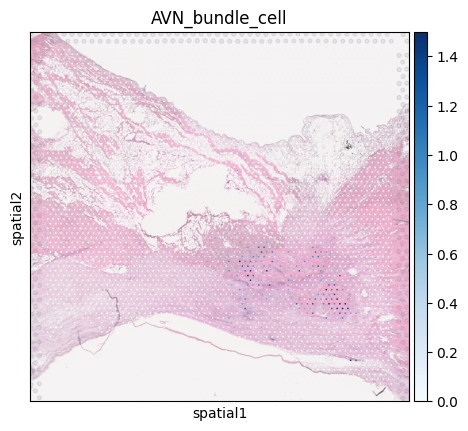

In [43]:
hearts1 = sc.read_h5ad('/home/emma/PycharmProjects/gobi/Semester/Exercise6/data/HCAHeartST10659160.h5ad')
hearts2 = sc.read_h5ad('/home/emma/PycharmProjects/gobi/Semester/Exercise6/data/HCAHeartST13228103.h5ad')

obsm_layer = 'q05_cell_abundance_w_sf'
types = ['SAN_P_cell', 'AVN_P_cell', 'AVN_bundle_cell']

for adata in [hearts1, hearts2]:
    for ct in types:
        if f'q05cell_abundance_w_sf_{ct}' in adata.obsm[obsm_layer].columns:
            adata.obs[ct] = adata.obsm[obsm_layer][f'q05cell_abundance_w_sf_{ct}']
        else:
            print('error')

# couldnt get squidpy spatial scatter to work :/
sc.pl.spatial(
    hearts1,
    color='SAN_P_cell',
    img_key='hires',
    spot_size=50,
    alpha_img=0.8,
    cmap='Blues',
    vmin=0,
    vmax=1.5,
)

sc.pl.spatial(
    hearts2,
    color='AVN_P_cell',
    img_key='hires',
    spot_size=50,
    alpha_img=0.8,
    cmap='Blues',
    vmin=0,
    vmax=1.5,
)

sc.pl.spatial(
    hearts2,
    color='AVN_bundle_cell',
    img_key='hires',
    spot_size=50,
    alpha_img=0.8,
    cmap='Blues',
    vmin=0,
    vmax=1.5,
)

## Exercise 2: spatial statistics on cell type resolved data

In this part of the exercise you will look at cell type resolved data from human heart tissue that was profiled on the 10X genomics Xenium platform.

In [44]:
url_dict = {
    # Ex 2
    "cell_feature_matrix.h5": "https://hmgubox2.helmholtz-muenchen.de/index.php/s/6mPbYEb53xR3mKy/download",
    "cells_annotated.csv": "https://hmgubox2.helmholtz-muenchen.de/index.php/s/NiaBtWAEjrDDN8g/download",
}

for file in url_dict.keys():
    print(f"Downloading {file}...")
    urlretrieve(url_dict[file], DATA_DIR / file)

The next code chunk loads the data and plots the cell type annotation on the spatial coordinates. The cell types are annotated as:

| Annotation | Cell type |
|------------|-----------|
| CM | cardiomyocytes |
| EC | endothelial cells |
| FB | fibroblasts |
| Leuko | leukocytes |
| NC | neuronal cells |
| PC | pericytes |
| SMC | smooth muscle cells |

/usr/lib/python3.12/functools.py:909: ImplicitModificationWarning: Transforming to str index.
  return dispatch(args[0].__class__)(*args, **kw)


/home/emma/PycharmProjects/gobi/.venv/lib/python3.12/site-packages/squidpy/pl/_spatial_utils.py:982: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


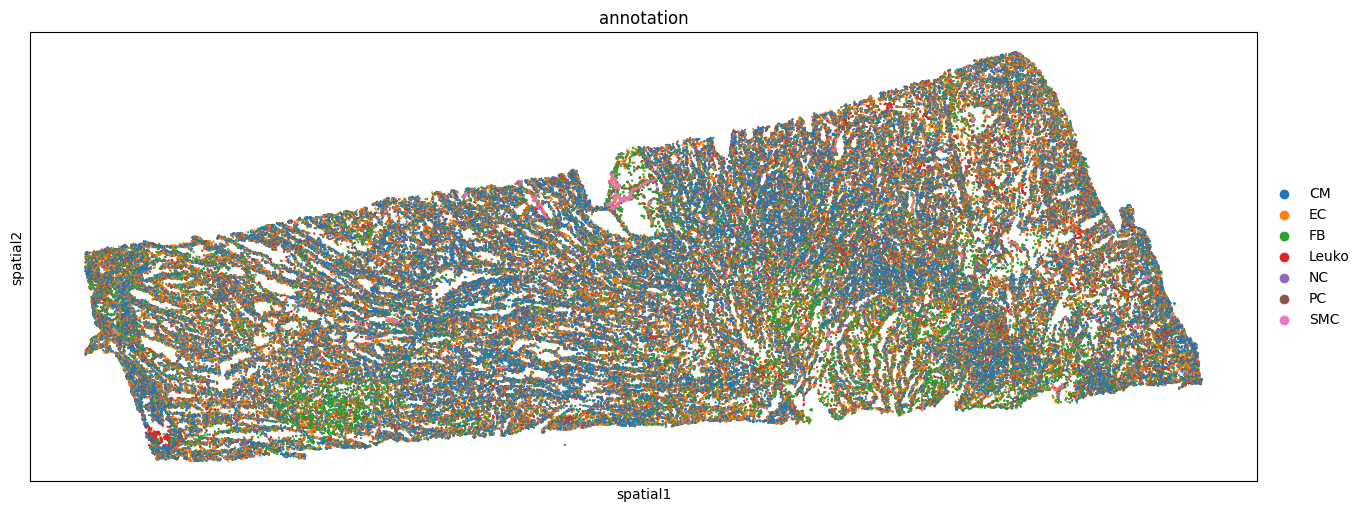

In [45]:
adata = sc.read_10x_h5(filename = "%s/cell_feature_matrix.h5" % DATA_DIR)
cells = pd.read_csv("%s/cells_annotated.csv" % DATA_DIR)
adata = adata[cells.index]
adata.obs = cells.copy()
adata.obsm["spatial"] = adata.obs[["y_centroid", "x_centroid"]].copy().to_numpy()

sq.pl.spatial_scatter(
    adata, color="annotation", shape=None, figsize=(16, 5)
)

### Exercise 2.1: Identify neighborhood enrichment (5 points)
In this exercise the aim is to identfy whether specific cell types are preferentially localized next to cells of specific other cell types.

a) Check out the squidpy [Xenium tutorial](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html) to run the neighborhood enrichment analysis using the anndata object that we just loaded and `cluster_key="annotation"`. Create a heatmap plot and describe the result:
 - what does the color code indicate?
 - what is the interpretation of positive and negative values?
 - which is the highest value that you observe and how do you interpret it?

b) Plot the spatial distribution of the three cell types that are most frequent in vessel walls. What do you observe? How is this related to the results of part a)?


100%|██████████| 1000/1000 [00:20<00:00, 48.85/s]


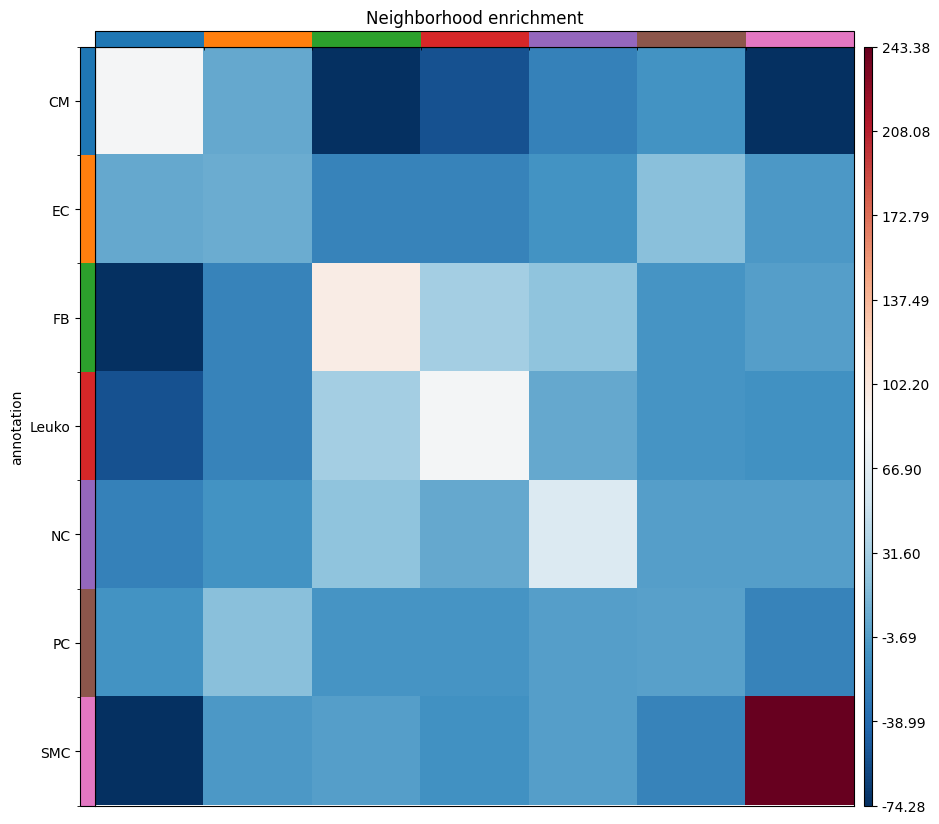

In [46]:
# solution a
sq.gr.spatial_neighbors(adata, coord_type="generic", delaunay=True)
sq.gr.nhood_enrichment(adata, cluster_key="annotation")

sq.pl.nhood_enrichment(adata, cluster_key="annotation", cmap="RdBu_r", linewidths=0.02, figsize=(8,8))

solution a (cont.)

 - what does the color code indicate?
  --> the z-score (red=enriched)
 - what is the interpretation of positive and negative values?
  --> positive values mean that two clusters neighbour each other more often than expected by randomness (= spatial association), negative values mean the opposite
 - which is the highest value that you observe and how do you interpret it?
  --> SMC self-enrichment, this means SMCs neighbour other SMCs more than expected by randomness

In [58]:
# solution b
#vessel_types = ["SMC1_basic", "PC1_vent", "EC5_art"] # TODO: what types exactly?
#sq.pl.spatial_scatter(adata, color=vessel_types, shape=None, size=1.5, ncols=3)

# 1. Get exact enrichment key & clusters
enr_key = 'annotation_nhood_enrichment'
enr_matrix = adata.uns[enr_key]
clusters = adata.obs["annotation"].cat.categories
enr_df = pd.DataFrame(enr_matrix, index=clusters, columns=clusters).astype(float)

# Now nlargest works!
print("\nTop overall enrichments:")
print(enr_df.stack().nlargest(10))

print("\nSMC row top neighbors:")
smc_rows = enr_df[enr_df.index.str.contains('SMC')]
if not smc_rows.empty:
    top = smc_rows.iloc[0].nlargest(5)
    print(top)
    print("Vessel types:", top.index.tolist())




Top overall enrichments:
Series([], dtype: float64)

SMC row top neighbors:
CM      NaN
EC      NaN
FB      NaN
Leuko   NaN
NC      NaN
Name: SMC, dtype: float64
Vessel types: ['CM', 'EC', 'FB', 'Leuko', 'NC']


### Exercise 2.2: co-occurrence analysis (5 points)
A more general analysis of co-occurence patterns can be performed when not only the direct neighbors but also cells at greater distances are considered.

a) Check out the squidpy [Xenium tutorial](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_xenium.html) to run the co-occurrence analysis using the anndata object that we just loaded and `cluster_key="annotation"`. Focus this analysis on smooth muscle cells (SMC).

b) Create the co-occurence plot for SMCs. Describe the plot: what is shown on each of the axes? How do you interprete the result for SMCs? Which tissue structure could explain this observation?

_Note_: you can speed up the computations by restricting the analyses to a smaller patch on the image, for example by subsetting the ann data object with this expression `(adata.obs["x_centroid"] > 4000) & (adata.obs["x_centroid"] < 6000) & (adata.obs["y_centroid"] > 5000) & (adata.obs["y_centroid"] < 10000)`

In [66]:
# solution a
# speed up computation
mask = (
    (adata.obs["x_centroid"] > 4000) & (adata.obs["x_centroid"] < 6000) &
    (adata.obs["y_centroid"] > 5000) & (adata.obs["y_centroid"] < 10000)
)
adata_subset = adata[mask].copy()

sq.gr.co_occurrence(adata_subset, cluster_key="annotation")

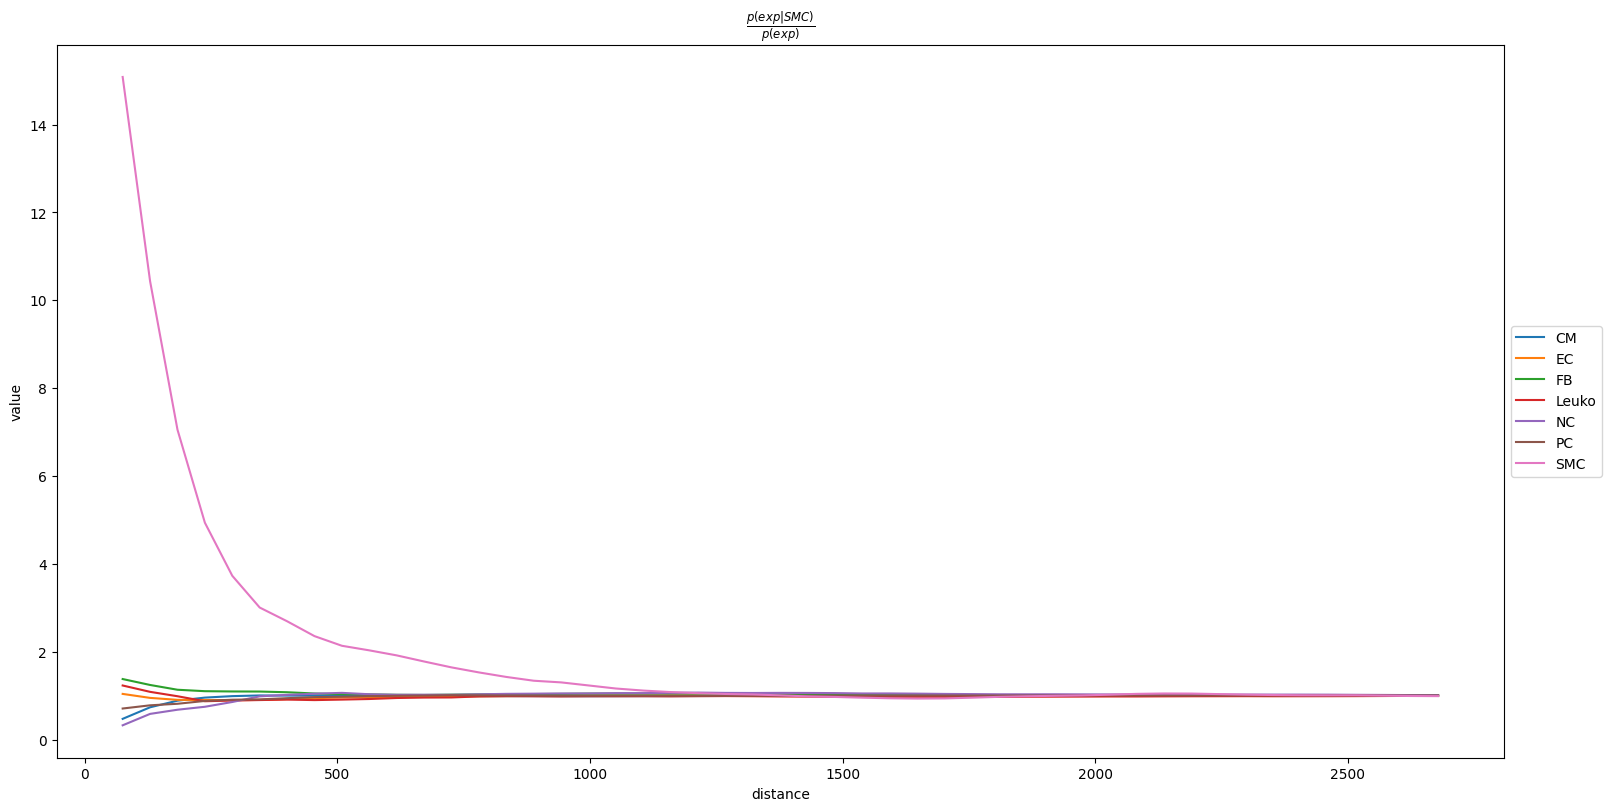

In [64]:
# solution b
sq.pl.co_occurrence(adata_subset, cluster_key="annotation", clusters = 'SMC', figsize=(16, 8))

- What is shown on each of the axes: the x axis shows the distance from SCM cells in micro metres, the Y axis shows the log co-occurrence ratio (so the probability of finding a neighbour cell type at that distance)
- how do you interpret the results for SMC:associations weaken with distance, SMCs being close to each other is very likely, which supports the previously shown heatmap/ data
- what tissue structure could explain this observation: vessel walls

### Exercise 2.3: Identify genes with spatial gene expression (5 points)

Use the squidpy function [`squidpy.gr.autocorr`](https://squidpy.readthedocs.io/en/stable/api/squidpy.gr.spatial_autocorr.html) to identify three different types  spatially patterned genes:

a) Find the top 3 genes with the highest Moran's I

b) Find the top 3 genes with the highest Moran's I after filtering for genes that are expressed in at least 10% of cells

c) Find the top 3 genes with the lowest Moran's I after filtering for genes that are expressed in at least 10% of cells

Use the squidpy function [`squidpy.pl.spatial_scatter`](https://squidpy.readthedocs.io/en/stable/api/squidpy.pl.spatial_scatter.html) to plot the spatial expression pattern of each of the top 3 genes from a)-c).


In [71]:
# solution
# Morans I for all genes:
sq.gr.spatial_autocorr(adata, mode='moran', n_jobs=-1)

moran_df = adata.uns['moranI']

# solution a
top3_high_all = moran_df.nlargest(3, 'I')[['I']]
print("a) Top 3 highest Moran's I:\n", top3_high_all)

# solution b
n_cells = adata.n_obs * 0.1
expr_genes = (adata.X > 0).sum(0) >= n_cells
top3_high_filtered = moran_df[expr_genes.A1.flatten()].nlargest(3, 'I')[['I']]
print("\nb) Top 3 high (>=10% cells):\n", top3_high_filtered)

# solution c
top3_low_filtered = moran_df[expr_genes.A1.flatten()].nsmallest(3, 'I')[['I']]
print("\nc) Top 3 lowest (>=10% cells):\n", top3_low_filtered)

a) Top 3 highest Moran's I:
                I
MYH11   0.181859
ACTA2   0.108442
ANKRD1  0.104069

b) Top 3 high (>=10% cells):
               I
MMRN1  0.102727
MYH7   0.097787
CXCL9  0.094062

c) Top 3 lowest (>=10% cells):
                 I
SPI1    -0.002024
COL17A1 -0.001791
CCDC39  -0.001323


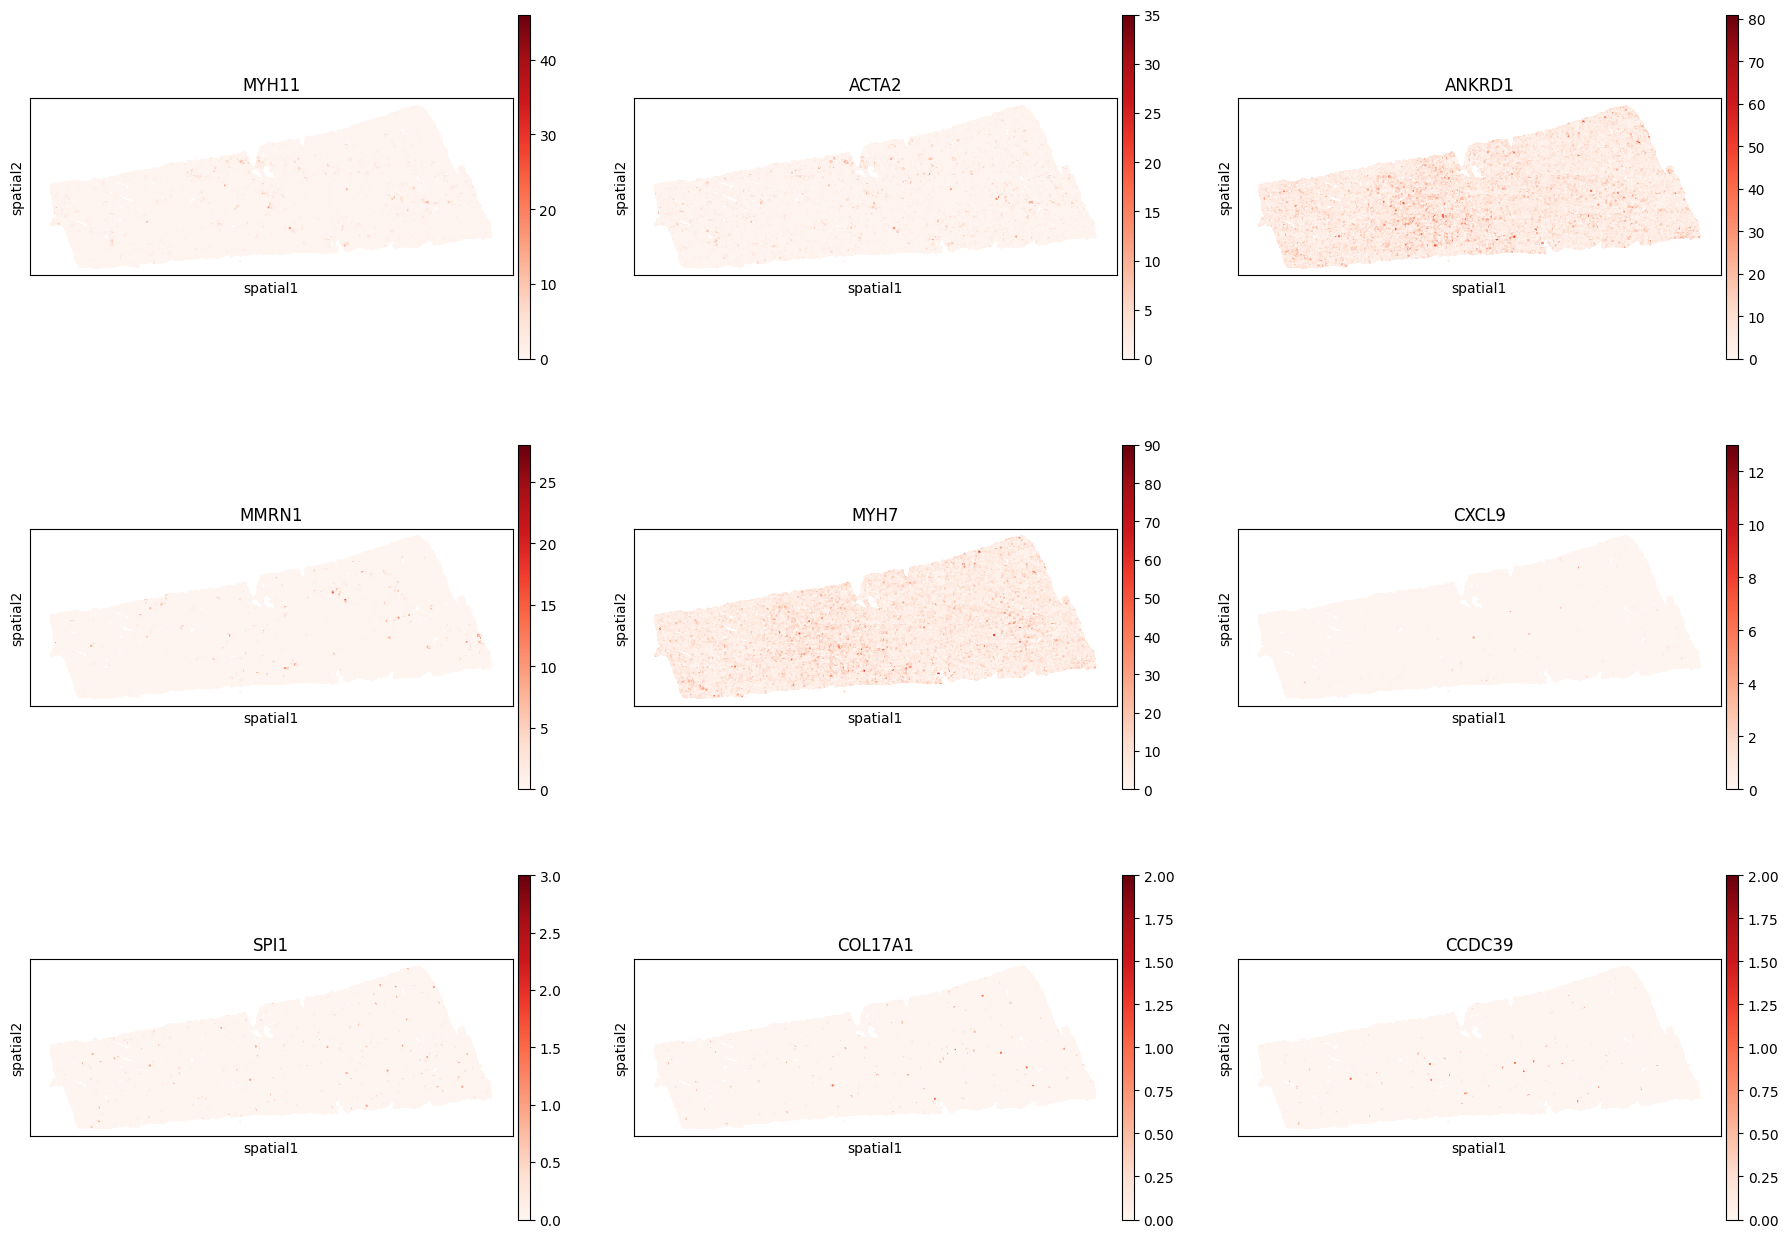

In [74]:
# plot
genes_a = top3_high_all.index.tolist()
genes_b = top3_high_filtered.index.tolist()
genes_c = top3_low_filtered.index.tolist()
all_genes = genes_a + genes_b + genes_c

sq.pl.spatial_scatter(adata, color=all_genes, shape=None, size=1.5, ncols=3, vmin=0, cmap='Reds')